# Plotting Newspaper Data
An example of how to use the eLuxemburgensia digital collection and plotting to visually display data.

This project uses Jupyter Notebooks to encapsulate all information regarding the project. The notebook requests the a date range from the user. It then uses those dates to select a list of newspapers published during that time period. The newspapers are then plotted showing their periodicity.

## Requirements
* Python 3.12
* [requests](https://pypi.org/project/requests/): HTTP library to run HTTP requests
* [pandas](https://pandas.pydata.org/): format the output into tabular layout
* [yarl](https://pypi.org/project/yarl/): format the output URL into a clickable URL link
* [untangle](https://pypi.org/project/untangle/): parse the MARC XML record

In [25]:
%pip install requests
%pip install pandas
%pip install yarl
%pip install untangle
%pip install plotly

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [26]:
from datetime import datetime
import requests
import pandas as pd
import untangle
import plotly.express as px

In [27]:
# Request the start date from the user   
while (True):
    input_date = input("Enter the start date (dd/mm/yyyy):")
    try:
        start_date_value = datetime.strptime(input_date,'%d/%m/%Y')
        break
    except:
        print("Please enter a valid date in the format dd/mm/yyyy.")
        

Enter the start date (dd/mm/yyyy): 01/01/1400


In [28]:
# Request the end date from the user
while (True):
    input_date = input("Enter the end date (dd/mm/yyyy):")
    try:
        end_date_value = datetime.strptime(input_date,'%d/%m/%Y')
        break
    except:
        print("Please enter a valid date in the format dd/mm/yyyy.")

Enter the end date (dd/mm/yyyy): 31/12/2025


In [29]:
# get the BnL eluxembourgensia collection
elux_collection = requests.get("https://viewer.eluxemburgensia.lu/api/viewer2/cms/v2/digitalcollections")
elux_collection = elux_collection.json()

In [30]:
# to display all the rows in the table - otherwise, some rows are hidden
pd.set_option('display.max_rows', None)

filtered_newspapers = []
plotting_data = []
for newspaper in elux_collection["data"]:
    newspaper_dict = {}
    frequency_dict = {}
    newspaper_start_date = newspaper["startdate"]
    try:
        newspaper_end_date = newspaper["enddate"]
    except:
        newspaper_end_date = "9999-12-31"
    if newspaper_start_date <= end_date_value.strftime("%Y-%m-%d") and newspaper_end_date >= start_date_value.strftime("%Y-%m-%d"):
        # Newspaper published between the selected dates so get the link to a-z
        az_link = newspaper["az_url"]
        
        # parse out the docid that starts with docid=alma and ends with the following '&'
        # find the starting point and add the 10 characters to skip the text "docid=alma"
        start_position = az_link.find("docid=alma") + 10
        
        # find the first ampersand after the starting position
        end_position = az_link.find("&",start_position)
        
        # build the corresponding doc_id
        doc_id = "oai:alma.352LUX_BIBNET_NETWORK:" + az_link[start_position:end_position]
        
        # build the url to get the marc data for the given newspaper
        marc_url = "https://oai.bibnet.lu/view/oai/352LUX_BIBNET_NETWORK/request?verb=GetRecord&metadataPrefix=marc21&identifier=" + doc_id
        marc_record_xml = requests.get(marc_url)

        # check for an error
        try:
            record_data = untangle.parse(marc_record_xml.text).OAI_PMH.GetRecord
        except:
            # skip this entry
            continue
            
        # get the newspaper data record by parsing the XML and then navigating to the correct record level
        newspaper_data = record_data.record.metadata.record

        # find the datafield with tag 310 = frequency of the newspaper
        for data_field in newspaper_data.datafield:
            if data_field['tag'] == "310":
                sub_field = data_field.subfield
                # if the sub_field is a list, then loop through list to find the entry with code = a
                # otherwise get the data directly from the subfield.
                if isinstance(sub_field, list):
                    for field in sub_field:
                        if field['code'] == "a":
                            frequency = field.cdata
                            break
                else:
                    if sub_field['code'] == "a":
                        frequency = data_field.subfield.cdata
                            
                    # add the newspaper to the dict with its frequency
                    newspaper_dict = {'Title': newspaper["title"],'Start Date': newspaper_start_date, 'End Date': newspaper_end_date, 'Frequency': frequency}
                    filtered_newspapers.append(newspaper_dict)

                    # find entry in plotting_data with the given frequency
                    count = 0
                    result_dict = None
                    for sub in plotting_data:
                        if sub['Frequency'] == frequency:
                            result_dict = sub
                            break

                    # if the result is the type "None", then add the frequency entry
                    if result_dict == None:
                        count += 1
                        frequency_dict = {'Frequency': frequency, 'Count': count}
                        plotting_data.append(frequency_dict)
                    else:
                        # increase the count by 1 
                        count = result_dict.get('Count')
                        count += 1
                        # by setting the new count in the dict, it is automatically updated in the list
                        result_dict['Count'] = count
                        

In [35]:
# temporarily display the data to be plotted
plotting_data

[{'Frequency': 'Trois fois par semaine', 'Count': 4},
 {'Frequency': 'Mode de parution non déterminé', 'Count': 9},
 {'Frequency': 'Mensuel', 'Count': 13},
 {'Frequency': 'Hebdomadaire', 'Count': 38},
 {'Frequency': 'Irrégulière', 'Count': 1},
 {'Frequency': 'Bihebdomadaire', 'Count': 9},
 {'Frequency': 'quotidien', 'Count': 1},
 {'Frequency': 'Trimestriel', 'Count': 4},
 {'Frequency': 'Autre', 'Count': 16},
 {'Frequency': 'Bimensuel', 'Count': 6},
 {'Frequency': 'Mensuel ; à partir de 1925 trimestriel', 'Count': 1},
 {'Frequency': '7-8 fois par an', 'Count': 1},
 {'Frequency': 'Inconnu', 'Count': 3},
 {'Frequency': 'Annuel', 'Count': 3},
 {'Frequency': 'Quotidien', 'Count': 6},
 {'Frequency': 'Paraît 6 fois par an', 'Count': 1},
 {'Frequency': 'Au moins 12 fois par an', 'Count': 1}]

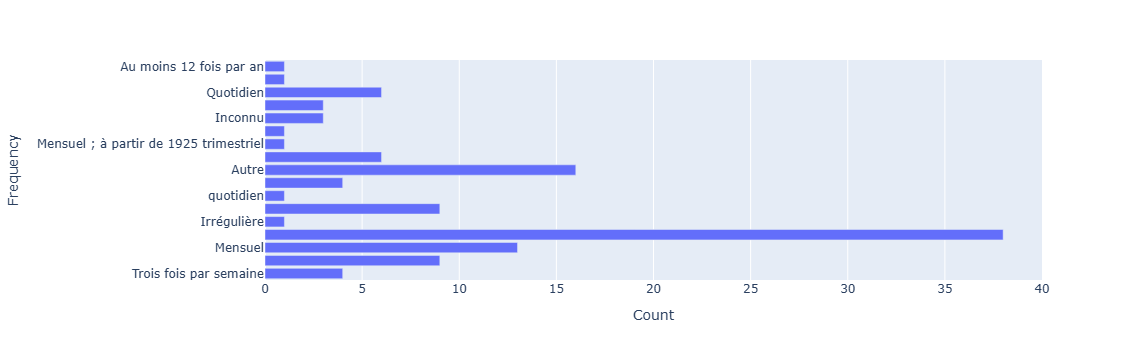

In [32]:
fig = px.bar(plotting_data, x='Count', y='Frequency')
fig.show()

In [33]:
# select only those newspapers published between the start date and end date
print("Newspapers published between " + start_date_value.strftime('%d/%m/%Y') + " - " + end_date_value.strftime('%d/%m/%Y') + ":")

# temporary display to show results up until this point
df = pd.DataFrame(filtered_newspapers, columns=["Title", "Start Date", "End Date", "Frequency"])
dfStyler = df.style.set_properties(**{'text-align': 'left'})
dfStyler.set_table_styles([dict(selector='th', props=[('text-align', 'left')])])

Newspapers published between 01/01/1400 - 31/12/2025:


,Title,Start Date,End Date,Frequency
0,Luxemburger Volks-Freund,1869-02-23,1876-12-31,Trois fois par semaine
1,Luxemburger Obstbaufreund,1895-01-01,9999-12-31,Mode de parution non déterminé
2,Cäcilia,1862-01-01,1871-12-01,Mensuel
3,Wegweiser (Der),1918-07-27,1919-12-13,Hebdomadaire
4,Letzeburgerin (D'),1945-11-01,1946-09-01,Irrégulière
5,Volksstimme (Die),1896-01-01,1896-06-07,Bihebdomadaire
6,Luxembourg (Le) : Journal du matin,1935-02-16,1940-05-10,quotidien
7,Hémecht,1948-07-01,9999-12-31,Trimestriel
8,Clarté,1945-05-26,1945-12-29,Hebdomadaire
9,Verordnungsblatt für Luxemburg,1940-05-10,1944-08-24,Autre
